In [7]:
import pandas as pd
import numpy as np

import os
os.chdir('/home/spankaew/Git/astrologics')
import astrologics as le

In [8]:
model_name = 'Human Gonadal Sex Determination_26573569'

In [9]:
attractor_path = '/home/spankaew/Git/astrologics/data/attractor_group/calculated_attractor/' + model_name + '_attractors.csv'
attractor_data = pd.read_csv(attractor_path, index_col = 0)

In [10]:
attractor_data

,bn_411,bn_361,bn_60,bn_109,bn_975,bn_265,bn_784,bn_595,bn_34,bn_624,bn_520,bn_980,bn_529,bn_461,bn_300,bn_985,bn_818,bn_707,bn_421,bn_631,bn_399,bn_152,bn_708,bn_380,bn_108,bn_393,bn_129,bn_314,bn_918,bn_54,bn_179,bn_722,bn_554,bn_213,bn_192,bn_958,bn_676,bn_503,bn_119,bn_521,bn_460,bn_117,bn_934,bn_391,bn_823,bn_872,bn_717,bn_576,bn_811,bn_833,bn_571,bn_454,bn_839,bn_339,bn_161,bn_405,bn_301,bn_928,bn_228,bn_894,bn_432,bn_667,bn_85,bn_476,bn_410,bn_120,bn_773,bn_887,bn_856,bn_158,bn_546,bn_323,bn_962,bn_51,bn_840,bn_542,bn_885,bn_330,bn_849,bn_502,bn_900,bn_892,bn_555,bn_217,bn_316,bn_653,bn_589,bn_701,bn_560,bn_553,bn_508,bn_758,bn_353,bn_212,bn_67,bn_527,bn_914,bn_336,bn_271,bn_154,bn_388,bn_829,bn_105,bn_853,bn_635,bn_869,bn_696,bn_704,bn_39,bn_563,bn_446,bn_311,bn_801,bn_543,bn_436,bn_258,bn_313,bn_779,bn_939,bn_990,bn_174,bn_480,bn_101,bn_198,bn_967,bn_90,bn_898,bn_11,bn_94,bn_587,bn_378,bn_92,bn_545,bn_444,bn_407,bn_294,bn_156,bn_598,bn_96,bn_870,bn_494,bn_769,bn_699,bn_329,bn_195,bn_987,bn_95,bn_425,bn_976,bn_71,bn_718,bn_64,bn_475,bn_977,bn_620,bn_348,bn_804,bn_387,bn_884,bn_498,bn_889,bn_836,bn_523,bn_70,bn_398,bn_512,bn_242,bn_905,bn_677,bn_260,bn_482,bn_72,bn_864,bn_785,bn_593,bn_91,bn_695,bn_578,bn_499,bn_15,bn_20,bn_935,bn_767,bn_202,bn_286,bn_999,bn_815,bn_150,bn_513,bn_139,bn_138,bn_910,bn_204,bn_906,bn_255,bn_383,bn_44,bn_516,bn_989,bn_413,bn_897,bn_173,bn_703,bn_564,bn_896,bn_462,bn_240,bn_440,bn_789,bn_912,bn_113,bn_754,bn_702,bn_723,bn_42,bn_488,bn_18,bn_297,bn_243,bn_235,bn_187,bn_949,bn_690,bn_496,bn_493,bn_270,bn_291,bn_537,bn_403,bn_658,bn_798,bn_55,bn_145,bn_75,bn_619,bn_511,bn_778,bn_289,bn_350,bn_908,bn_249,bn_807,bn_533,bn_77,bn_368,bn_178,bn_254,bn_645,bn_199,bn_434,bn_825,bn_647,bn_298,bn_716,bn_686,bn_850,bn_609,bn_875,bn_917,bn_762,bn_592,bn_966,bn_929,bn_276,bn_168,bn_56,bn_491,bn_17,bn_16,bn_206,bn_886,bn_167,bn_649,bn_295,bn_916,bn_408,bn_651,bn_278,bn_472,bn_787,bn_401,bn_666,bn_49,bn_115,bn_964,bn_923,bn_259,bn_562,bn_599,bn_681,bn_988,bn_515,bn_924,bn_183,bn_290,bn_430,bn_660,bn_991,bn_79,bn_650,bn_737,bn_616,bn_362,bn_893,bn_14,bn_123,bn_873,bn_782,bn_837,bn_524,bn_371,bn_585,bn_981,bn_519,bn_909,bn_816,bn_827,bn_490,bn_87,bn_147,bn_891,bn_466,bn_305,bn_463,bn_797,bn_874,bn_858,bn_776,bn_953,bn_832,bn_851,bn_257,bn_899,bn_372,bn_293,bn_89,bn_404,bn_209,bn_994,bn_93,bn_559,bn_625,bn_812,bn_306,bn_605,bn_780,bn_28,bn_810,bn_248,bn_501,bn_684,bn_859,bn_793,bn_878,bn_48,bn_691,bn_374,bn_665,bn_541,bn_441,bn_384,bn_867,bn_662,bn_518,bn_761,bn_103,bn_288,bn_951,bn_82,bn_792,bn_652,bn_304,bn_841,bn_694,bn_427,bn_360,bn_210,bn_31,bn_185,bn_419,bn_400,bn_526,bn_720,bn_913,bn_149,bn_965,bn_269,bn_345,bn_30,bn_414,bn_478,bn_963,bn_715,bn_303,bn_321,bn_245,bn_640,bn_760,bn_697,bn_791,bn_479,bn_740,bn_727,bn_756,bn_504,bn_46,bn_52,bn_663,bn_509,bn_191,bn_234,bn_730,bn_151,bn_141,bn_486,bn_819,bn_207,bn_328,bn_633,bn_842,bn_216,bn_721,bn_594,bn_218,bn_477,bn_569,bn_99,bn_517,bn_443,bn_471,bn_860,bn_926,bn_993,bn_189,bn_904,bn_230,bn_137,bn_495,bn_881,bn_689,bn_626,bn_600,bn_634,bn_772,bn_451,bn_638,bn_551,bn_148,bn_643,bn_417,bn_264,bn_470,bn_363,bn_98,bn_539,bn_719,bn_485,bn_712,bn_586,bn_157,bn_750,bn_835,bn_739,bn_222,bn_809,bn_568,bn_45,bn_386,bn_945,bn_733,bn_215,bn_130,bn_481,bn_601,bn_845,bn_219,bn_678,bn_655,bn_379,bn_159,bn_6,bn_950,bn_982,bn_820,bn_783,bn_692,bn_753,bn_646,bn_416,bn_606,bn_409,bn_252,bn_29,bn_68,bn_817,bn_996,bn_693,bn_890,bn_176,bn_69,bn_337,bn_352,bn_741,bn_356,bn_326,bn_429,bn_713,bn_675,bn_448,bn_590,bn_62,bn_377,bn_847,bn_274,bn_312,bn_59,bn_960,bn_334,bn_135,bn_630,bn_711,bn_752,bn_296,bn_940,bn_997,bn_986,bn_262,bn_32,bn_373,bn_522,bn_959,bn_153,bn_735,bn_724,bn_535,bn_610,bn_796,bn_931,bn_43,bn_757,bn_331,bn_668,bn_106,bn_50,bn_636,bn_794,bn_611,bn_865,bn_116,bn_131,bn_38,bn_602,bn_285,bn_671,bn_505,bn_710,bn_364,bn_381,bn_682,bn_13,bn_570,bn_322,bn_428,bn_84,bn_110,bn_220,bn_211,bn_229,bn_469,bn_648,bn_497,bn_318,bn_396,bn_193,bn_354,bn_114,bn_238,bn_705,bn_458,bn_7

In [11]:
model_path = '/home/spankaew/Git/astrologics/inferred_model/' + model_name  + '/'
model = le.LogicEnsemble(model_path, project_name = 'test')
model.create_simulation()

Simulation object created


In [ ]:
simulation_path = '/home/spankaew/Git/astrologics/data/simulation_files/' + model_name + '_simulation.csv'
model.simulation.simulation_df = pd.read_csv(simulation_path, index_col = 0)
model.create_trajectory()

Trajectory object created


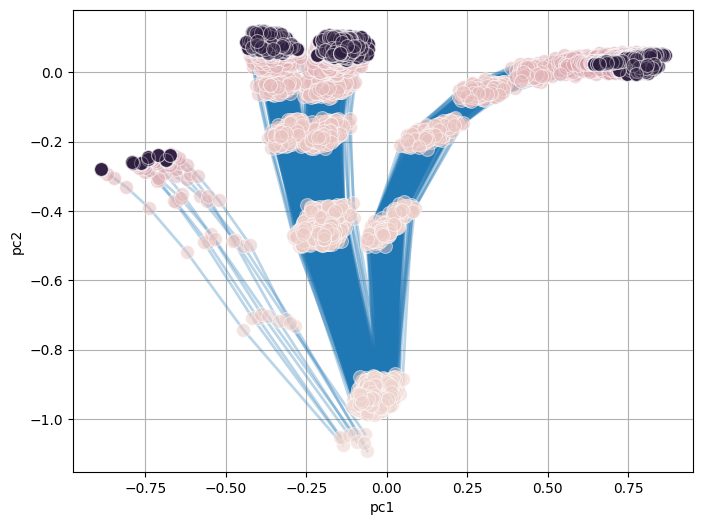

In [ ]:
model.trajectory.pca_trajectory()
model.trajectory.plot_pca_trajectory(color = 'timepoint')

In [28]:
model.trajectory.calculate_distancematrix(mode = 'trajectory')

Calculating distance matrix for whole trajectory...


100%|██████████| 1000/1000 [01:02<00:00, 15.88it/s]

Distance matrix calculated successfully.


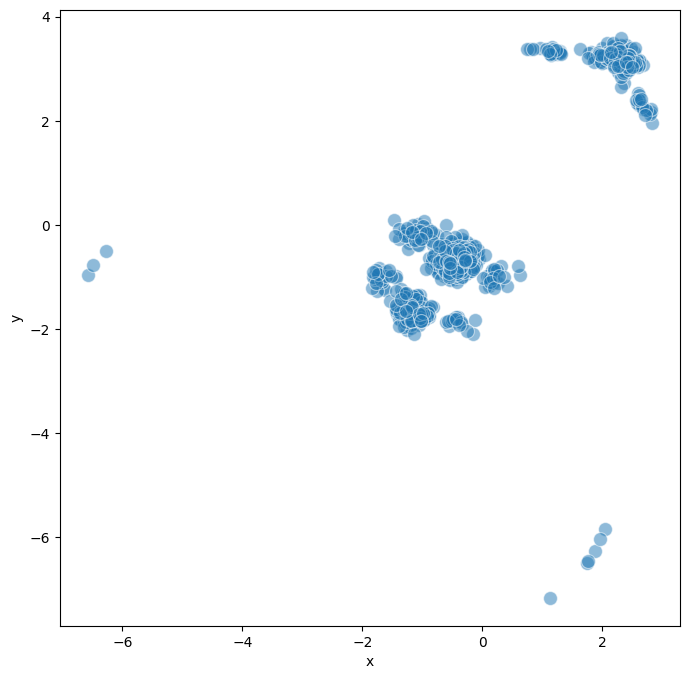

In [29]:
# Perform MDS (Multidimensional Scaling) for visualization
model.trajectory.calculate_MDS()
model.trajectory.plot_MDS(s = 100, fig_size = (8,8))

In [ ]:
model.trajectory.calculate_kmean_cluster(n_cluster= 5, random_state = 12345)

Calculated k-means clustering with 6 clusters.


In [38]:
attractor_group_path = '/home/spankaew/Git/astrologics/data/attractor_group/attractor_group/' + model_name + '_attractor_group.csv'
attractor_group = pd.read_csv(attractor_group_path, index_col = 0)
attractor_group_dict = attractor_group['attractor_group'].to_dict()

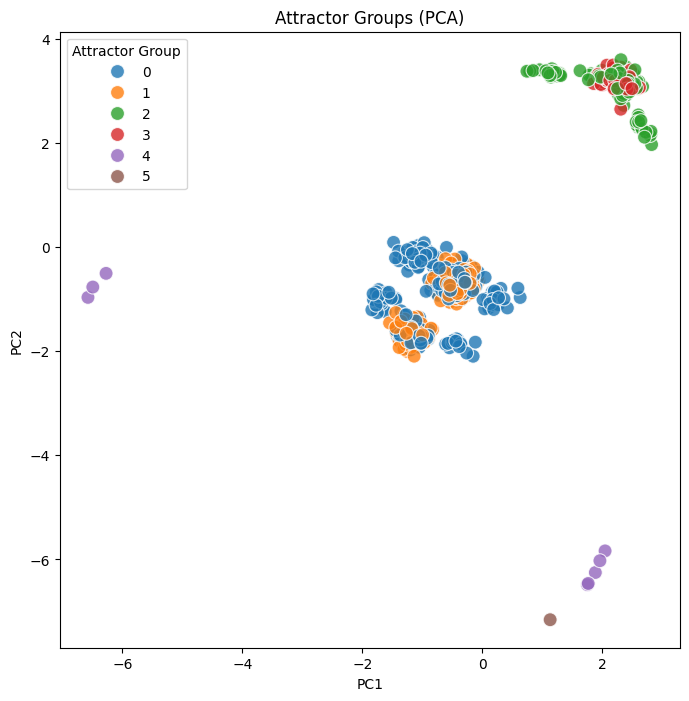

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
coords = model.trajectory.mds_coords
coords['attractor_group'] = coords.index.map(attractor_group_dict)

plt.figure(figsize=(8, 8))
sns.scatterplot(
    x=coords['x'],
    y=coords['y'],
    hue=coords['attractor_group'],
    palette='tab10',
    s=100,
    alpha=0.8
)
plt.legend(title="Attractor Group")
plt.grid(False)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Attractor Groups (PCA)')
plt.show()

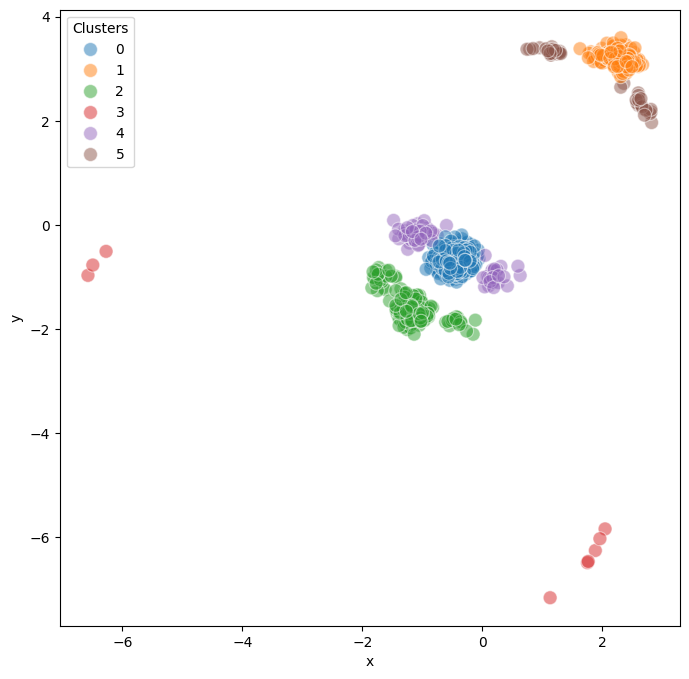

In [42]:
model.trajectory.plot_MDS(plot_cluster=True, fig_size = (8,8), s =100)